# *Seasonal model: all stores*

## 📚 **Libs**

In [43]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error


mpl.rcParams['figure.figsize'] = (12,12)
sns.set_theme(style="whitegrid", font_scale=1.5)

## 🗓️ **Holidays**

In [44]:
holidays_events = pd.read_csv(
    "data/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

display(holidays_events.head(2))
display(holidays_events.shape)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


(350, 5)

## 🏬 **Stores (train set)**

In [45]:
store_sales = pd.read_csv(
    'data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')

store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

display(store_sales.head())
display(store_sales.shape)

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

(3000888, 1)

## 🤑 **On promotion**

In [46]:
onpromotion = pd.read_csv(
    'data/train.csv',
    usecols=['date', 'onpromotion'],
    parse_dates=['date']
).groupby(['date']).sum().loc['2017']

onpromotion.head()

,onpromotion
date,
2017-01-01,170
2017-01-02,11812
2017-01-03,13906
2017-01-04,22918
2017-01-05,8550


## 📤 **Transactions**

In [47]:
trasactions = pd.read_csv(
    'data/transactions.csv',
    index_col='date',
    parse_dates=['date']
).groupby('date').sum().loc['2017']

trasactions = trasactions[['transactions']]
trasactions

,transactions
date,
2017-01-01,1642
2017-01-02,107718
2017-01-03,97185
2017-01-04,91527
2017-01-05,84930
...,...
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993


## 🎯 **Target: average sales of 2017**

In [48]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

display(average_sales.head(2))
display(average_sales.shape)

date
2017-01-01      6.780303
2017-01-02    786.928406
Freq: D, Name: sales, dtype: float32

(227,)

## 🎯 **Y**

#### Modeling the DataFrame shape for <mark>general forecasting</mark> (all stores)

In [49]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
display(y.head())
display(y.shape)

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   

                    
store_nbr           
family     SEAFOOD  
date                
2017-01-01     0.0  
2017-01-02    23.0  
2017-01-03    14.0  
2017-01-04     0.0  
2017-01-05    17.0  

[5 rows x 1782 columns]

(227, 1782)

## 🎨 **Seasonal Features**

#### Trend and Fourier

In [50]:
fourier = CalendarFourier(freq='Q', order=12) # Quarterly

dp = DeterministicProcess(
    index=average_sales.index, #y
    constant=False,
    order=1,
    additional_terms=[fourier],
    seasonal=True,
    drop=True
)

#### Holidays

In [51]:
holidays_2017 = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays_2017.head())
display(holidays_2017.shape)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi


(14, 1)

In [52]:
X_holidays = pd.get_dummies(holidays_2017.description)
display(X_holidays.head(2))
display(X_holidays.shape)

,Batalla de Pichincha,Carnaval,Dia de la Madre,Dia de la Madre-1,Dia del Trabajo,Primer Grito de Independencia,Primer dia del ano,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0


(14, 13)

#### Week Before Holiday

In [53]:
X_indexes = dp.in_sample().copy()
X_indexes.index = X_indexes.index.astype(str)
week_before_holiday = {}

In [54]:
for i in range(0, len(X_indexes.index)):
    if str(X_indexes.index[i]) == '2017-01-01' or str(X_indexes.index[i]) == '2017-01-02':
        week_before_holiday.update({X_indexes.index[i]: 0})
    else:
        if X_indexes.index[i] in holidays_2017.index:
            week_before_holiday.update({X_indexes.index[i]: 1})
            week_before_holiday.update({X_indexes.index[i-1]: 1})
            week_before_holiday.update({X_indexes.index[i-2]: 1})
            week_before_holiday.update({X_indexes.index[i-3]: 1})
            week_before_holiday.update({X_indexes.index[i-4]: 1})
            week_before_holiday.update({X_indexes.index[i-5]: 1})
            week_before_holiday.update({X_indexes.index[i-6]: 1})
        else:
            week_before_holiday.update({X_indexes.index[i]: 0})

# {'date': value}
# 1: True, 0: False
            

In [55]:
week_before_holiday = pd.DataFrame.from_dict(week_before_holiday, orient='index', columns=['week_before_holiday'])

In [56]:
display(week_before_holiday.head())
display(week_before_holiday.shape)

,week_before_holiday
2017-01-01,0
2017-01-02,0
2017-01-03,0
2017-01-04,0
2017-01-05,0


(227, 1)

## 🎨 **X**

In [57]:
X = dp.in_sample() # Fourier features
X = X.join(X_holidays, on='date').fillna(0.0) # Holidays
X = X.join(week_before_holiday, on=week_before_holiday.index) # 7 days before the holiday
X = X.join(onpromotion, on=onpromotion.index) # onpromotion column from train dataset
X = X.join(trasactions, on=trasactions.index) # transactions dataset
X['FathersMonth'] = (X.index.month == 6) # FathersMonth
X['StartSchoolSeason'] = (X.index.month == 4) | (X.index.month == 5) # Start of school season

In [58]:
X.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=Q-DEC)","cos(1,freq=Q-DEC)",...,Provincializacion de Imbabura,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo,week_before_holiday,onpromotion,transactions,FathersMonth,StartSchoolSeason
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0,170,1642,False,False
2017-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.069756,0.997564,...,0.0,0.0,0.0,1.0,0.0,0,11812,107718,False,False
2017-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.139173,0.990268,...,0.0,0.0,0.0,0.0,0.0,0,13906,97185,False,False
2017-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.207912,0.978148,...,0.0,0.0,0.0,0.0,0.0,0,22918,91527,False,False
2017-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.275637,0.961262,...,0.0,0.0,0.0,0.0,0.0,0,8550,84930,False,False


## 🔮 **Forecasting**

In [59]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [60]:
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
y_pred.head()

sales                                                      \
store_nbr              1                                                       
family        AUTOMOTIVE BABY CARE        BEAUTY     BEVERAGES         BOOKS   
date                                                                           
2017-01-01  5.326584e-11       0.0  1.612399e-11  5.928382e-08 -6.844081e-12   
2017-01-02  5.000000e+00       0.0 -1.170886e-11  1.434000e+03  2.068401e-12   
2017-01-03  3.010422e+00       0.0  5.503656e+00  2.895163e+03  1.320270e+00   
2017-01-04  2.051728e+00       0.0  5.295026e+00  2.902091e+03  1.288411e+00   
2017-01-05  3.531363e+00       0.0  3.371060e+00  2.443741e+03  9.153789e-01   

                                                                    \
store_nbr                                                            
family      BREAD/BAKERY   CELEBRATION      CLEANING         DAIRY   
date                                                                 
2017-01-01  1.157304e-09 -9.299761e-11  4.831577e-09  9.218979e-09   
2017-01-02  1.668190e+02 -9.958256e-12  3.320000e+02  3.760000e+02   
2017-01-03  4.897429e+02  2.044705e+01  9.466502e+02  9.586902e+02   
2017-01-04  5.336715e+02  1.746397e+01  1.020234e+03  1.017968e+03   
2017-01-05  4.569255e+02  2.076276e+01  7.825474e+02  8.330242e+02   

                          ...                                            \
store_nbr                 ...             9                               
family              DELI  ...     MAGAZINES         MEATS PERSONAL CARE   
date                      ...                                             
2017-01-01  2.289738e-09  ...  1.443290e-12 -2.225704e-10  3.990124e-10   
2017-01-02  4.498000e+01  ...  5.000000e+00  6.595700e+02  1.243000e+03   
2017-01-03  1.767167e+02  ...  2.375937e+00  5.030585e+02  8.119865e+02   
2017-01-04  1.603590e+02  ...  1.515199e+00  4.343899e+02  6.513312e+02   
2017-01-05  1.385667e+02  ...  1.979182e+00  6.046350e+02  5.988234e+02   

                                                                               \
store_nbr                                                                       
family      PET SUPPLIES PLAYERS AND ELECTRONICS       POULTRY PREPARED FOODS   
date                                                                            
2017-01-01 -1.934941e-11            3.481659e-13  3.231548e-10  -2.619949e-10   
2017-01-02  1.100000e+01            4.100000e+01  8.435960e+02   1.151890e+02   
2017-01-03  8.915084e+00            1.382766e+01  6.364961e+02   1.544176e+02   
2017-01-04  8.730327e+00            9.898837e+00  5.227218e+02   1.258525e+02   
2017-01-05  5.529908e+00            1.288231e+01  4.434110e+02   1.186289e+02   

                                                                   
store_nbr                                                          
family           PRODUCE SCHOOL AND OFFICE SUPPLIES       SEAFOOD  
date                                                               
2017-01-01 -1.591786e-09              -4.060752e-10 -6.456702e-11  
2017-01-02  3.136896e+03               1.000000e+00  2.300000e+01  
2017-01-03  2.994351e+03              -2.766228e+01  1.723705e+01  
2017-01-04  1.743476e+03              -3.274369e+01  1.069064e+01  
2017-01-05  1.606315e+03              -1.186778e+01  1.276867e+01  

[5 rows x 1782 columns]

### 📈 **Viewing**

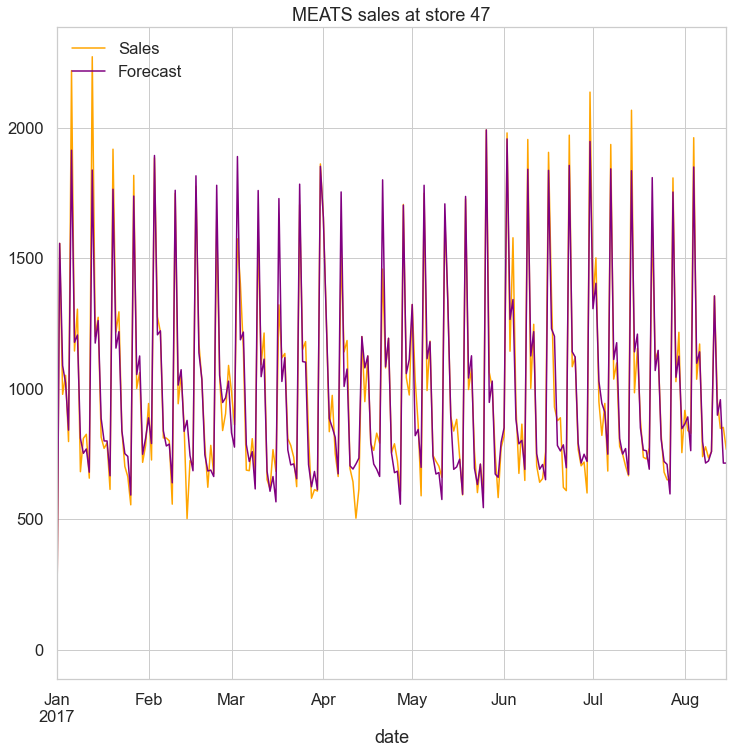

In [61]:

STORE_NBR = '47'  # 1 - 54
FAMILY = 'MEATS'
ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(color='orange', label='Sales')
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, color='purple', label='Forecast')
ax.set_title(f'{FAMILY} sales at store {STORE_NBR}');
plt.legend(loc='upper left');

## 💾 **Saving**

#### Changing the format from MultiIndex Columns to just one index column

In [62]:
# Copying so I don't mess with the original
aux = y_pred.copy()

In [63]:
# Undoing the unstacking and reseting the index to date
aux = aux.stack(['store_nbr', 'family']) 
aux.reset_index(inplace=True)
aux = aux.set_index('date')
display(aux.head())
display(aux.shape)

,store_nbr,family,sales
date,,,
2017-01-01,1,AUTOMOTIVE,5.326584e-11
2017-01-01,1,BABY CARE,0.000000e+00
2017-01-01,1,BEAUTY,1.612399e-11
2017-01-01,1,BEVERAGES,5.928382e-08
2017-01-01,1,BOOKS,-6.844081e-12


(404514, 3)

Saving...

In [64]:
#aux.to_csv('forecasting results/forecast_results_final.csv')

## 🔎 **Analyzing the model**

### **Features Importance**

Getting the coefficients from the model

In [65]:
importance = model.coef_[0]
importance # pesos de cada feature

array([ 8.51663496e-03, -2.23680361e+00, -1.33936773e+00, -6.49422585e-01,
        2.21379127e+00, -1.44980772e+00,  3.10095500e+00,  3.60655375e-01,
        6.14580350e-01,  4.36494514e-01,  5.92812309e-02,  5.82210798e-02,
        3.26453708e-02,  4.54739377e-01, -1.28779071e-01, -3.55331269e-02,
        3.19022608e-01, -2.45189295e-01,  1.70980015e-02, -9.10145853e-02,
       -5.33463472e-01, -2.80322543e-02,  1.01903567e-01, -5.31184763e-02,
        7.85314758e-01,  6.48059759e-02,  2.30833618e-01,  4.82562141e-01,
        1.26474441e-02, -8.47745831e-02,  3.21248356e-01,  2.24222456e-01,
        3.66415412e+00,  5.77660071e-01,  1.24453918e+00, -6.12074761e-01,
       -2.14860866e+00,  3.99164849e+00, -9.67777911e+00,  2.42691572e+00,
        3.92792761e-01, -4.47619010e+00, -5.42286801e+00,  2.31502967e+00,
       -5.26586459e+00,  7.43666822e-02, -3.92050754e-04, -3.75408221e-05,
        1.00369151e+00,  4.94698599e-01])

Dictionary

In [66]:
feature_score = {}
for i,v in enumerate(importance):
	feature_score[i] = v # {number: weight}

DataFrame

In [67]:
df_features_importance = pd.DataFrame.from_dict(feature_score, orient='index', columns=['score_original'])
df_features_importance['feature_name'] = X.columns
df_features_importance['abs_score'] = abs(df_features_importance.score_original)
df_features_importance.head()

,score_original,feature_name,abs_score
0,0.008517,trend,0.008517
1,-2.236804,"s(1,7)",2.236804
2,-1.339368,"s(2,7)",1.339368
3,-0.649423,"s(3,7)",0.649423
4,2.213791,"s(4,7)",2.213791


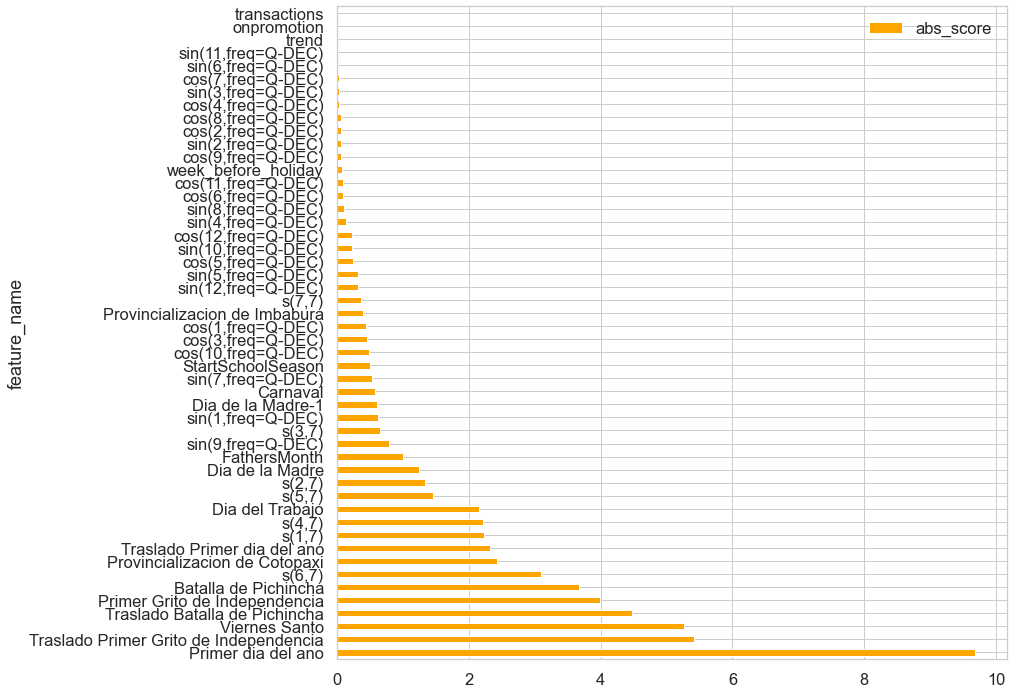

In [68]:
df_features_importance.sort_values(by='abs_score', ascending=False).plot(kind='barh', x='feature_name', y='abs_score', figsize=(12,12), color='orange');

Best 5 features

In [69]:
top_5_features = df_features_importance[['abs_score', 'feature_name']].sort_values(by='abs_score', ascending=False).head(5)
top_5_features

,abs_score,feature_name
38,9.677779,Primer dia del ano
42,5.422868,Traslado Primer Grito de Independencia
44,5.265865,Viernes Santo
41,4.476190,Traslado Batalla de Pichincha
37,3.991648,Primer Grito de Independencia


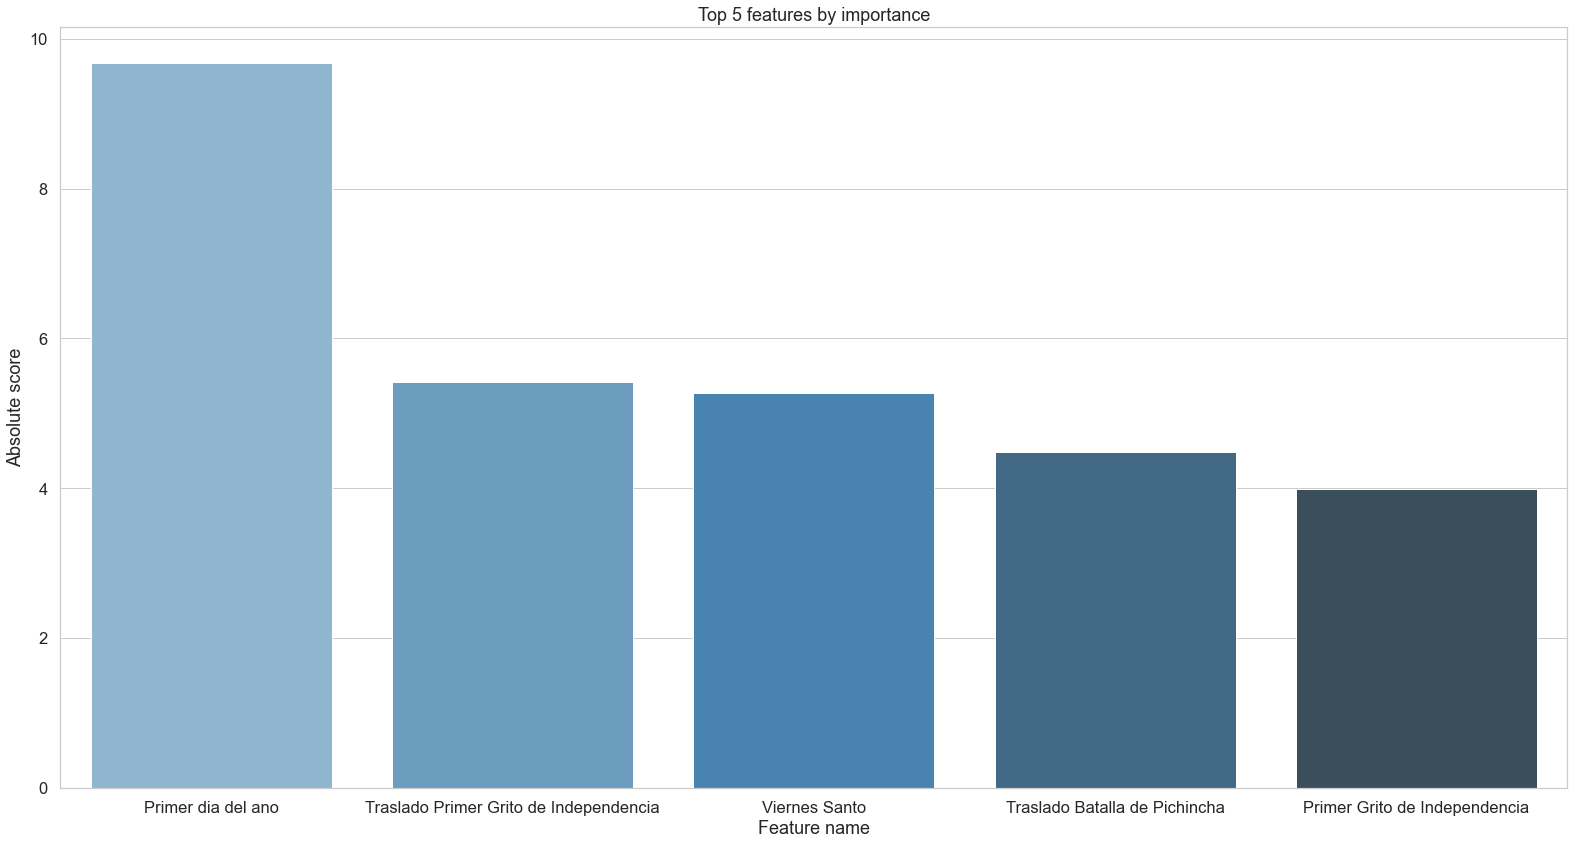

In [70]:
plt.figure(figsize=(27,14))
sns.barplot(x='feature_name', y='abs_score', data=top_5_features, palette='Blues_d').set_title('Top 5 features by importance')

plt.xlabel('Feature name')
plt.ylabel('Absolute score');

### **Metrics**

##### Changing the format from MultiIndex Columns to just one index column

###### Real y values

In [71]:
y_real = y.copy()
y_real = y_real.stack(['store_nbr', 'family']) 
y_real.reset_index(inplace=True)
y_real = y_real.set_index('date')

In [72]:
display(y_real.head())
display(y_real.shape)

,store_nbr,family,sales
date,,,
2017-01-01,1,AUTOMOTIVE,0.0
2017-01-01,1,BABY CARE,0.0
2017-01-01,1,BEAUTY,0.0
2017-01-01,1,BEVERAGES,0.0
2017-01-01,1,BOOKS,0.0


(404514, 3)

###### Predicted y values

In [73]:
y_previsto = aux.copy()
display(y_previsto.head())
display(y_previsto.shape)

,store_nbr,family,sales
date,,,
2017-01-01,1,AUTOMOTIVE,5.326584e-11
2017-01-01,1,BABY CARE,0.000000e+00
2017-01-01,1,BEAUTY,1.612399e-11
2017-01-01,1,BEVERAGES,5.928382e-08
2017-01-01,1,BOOKS,-6.844081e-12


(404514, 3)

#### **Mean Absolute Error**

In [74]:
mean_absolute_error(y_real.sales, y_previsto.sales).round(2)

44.58

#### **Mean Squared Error**

In [75]:
mean_squared_error(y_real.sales, y_previsto.sales).round(2)

29428.9

#### **Root Mean Squared Error**

In [76]:
mean_squared_error(y_real.sales, y_previsto.sales, squared=False).round(2)

171.55

#### **Root Mean Squared Logarithmic Error (Kaggle evaluation)**

###### RMSLE metric only considers the relative error between and the Predicted and the actual value and the scale of the error is not significant. On the other hand, RMSE value Increases in magnitude if the scale of error increases.

###### $$ Y = 10000 $$


###### $$ X = 9000 $$

###### Calculated RMSLE: 0.1053

###### Calculated RMSE : 1000

In [77]:
#mean_squared_log_error(y_real.sales, y_previsto.sales)

```python
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
```

##### **Using absolute values**

In [78]:
y_real_sales = y_real.sales.values
y_prev_sales = abs(y_previsto.sales.values)

In [79]:
mean_squared_log_error(y_real_sales, y_prev_sales)

0.25921421802835976

In [80]:
math.sqrt(mean_squared_log_error(y_real_sales, y_prev_sales))

0.5091308456854287

### **Scatters**

In [81]:
y_real_sales = y_real_sales.astype(float).round(2)
y_prev_sales = y_prev_sales.round(2)
residuals = y_real_sales - y_prev_sales

In [82]:
real_x_predicted = pd.DataFrame({'y_real': y_real_sales, 'y_prev': y_prev_sales, 'residual':residuals}, index=aux.index)
real_x_predicted['y_real'] = real_x_predicted.y_real
real_x_predicted.tail()

,y_real,y_prev,residual
date,,,
2017-08-15,438.13,339.57,98.56
2017-08-15,154.55,104.07,50.48
2017-08-15,2419.73,2228.79,190.94
2017-08-15,121.00,91.39,29.61
2017-08-15,16.00,18.60,-2.60


#### Real X Predicted

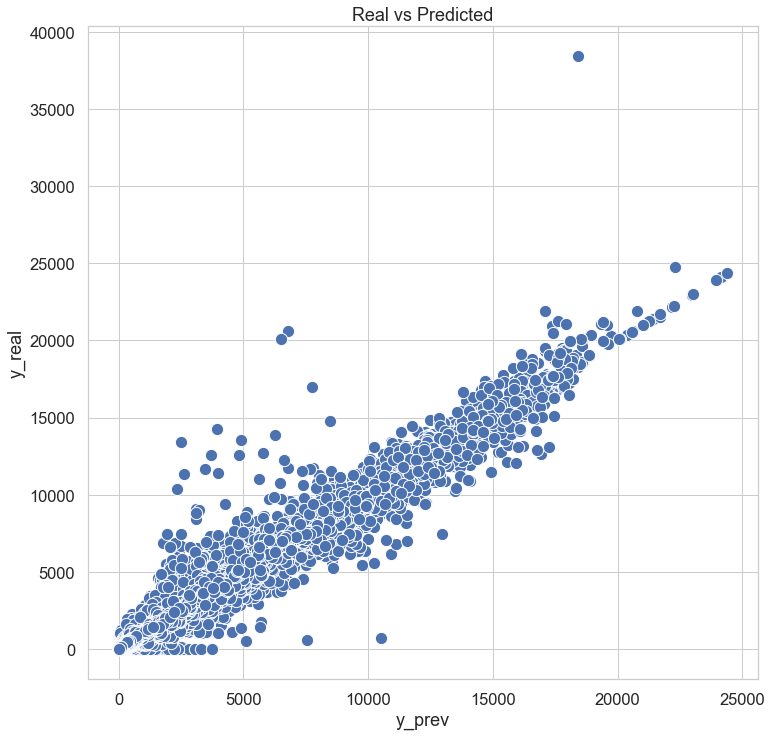

In [83]:
sns.scatterplot(
    x='y_prev', 
    y='y_real', 
    data=real_x_predicted, 
    palette='Blues_d', s=150
    ).set_title('Real vs Predicted');

#### Residuals

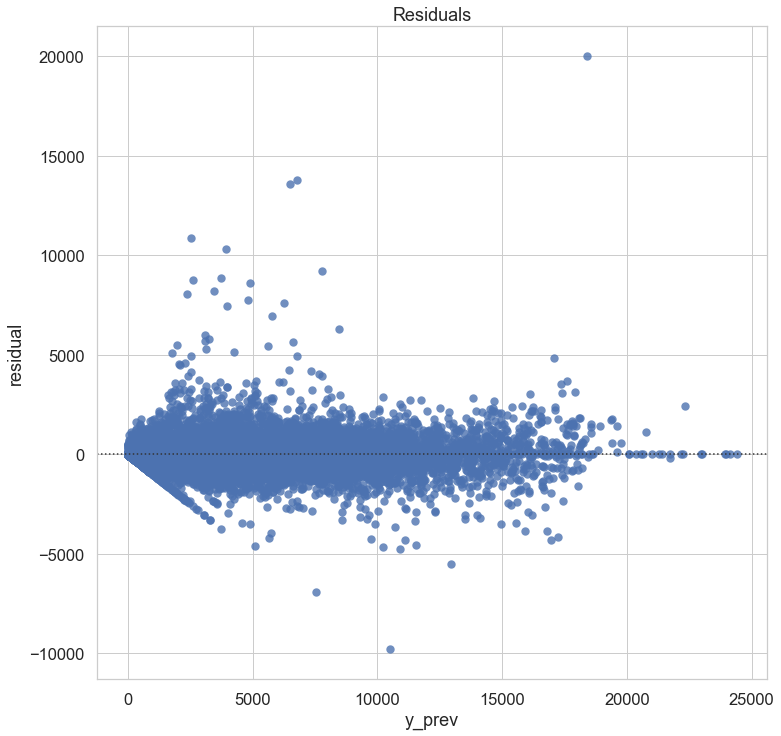

In [84]:
sns.residplot(
    x=real_x_predicted.y_prev, 
    y=real_x_predicted.residual, 
    data=real_x_predicted, 
    scatter_kws={'s':70},
    ).set_title('Residuals');